# Markov Drip Process

## Initial setup

In [11]:
import numpy as np
from scipy.optimize import Bounds, minimize
from scipy.interpolate import interp1d
from scipy.special import factorial
from scipy import integrate
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../python/')
import util
from ephys import Poisson

## Poisson distribution

### Create handling class
Moved to `ephys` module. See `../python/ephys.py` for implementation details.

### Test inter-event time sampling
This should be drawn from an exponential distribution: $t \sim \lambda e^{-\lambda t}$

Expected mean: 2.00000e+00
Actual mean: 2.04531e+00
Expected std: 2.00000e+00
Actual std: 2.03705e+00


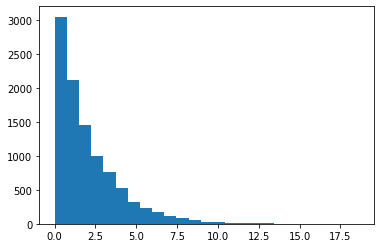

In [2]:
# Settings
lam = 0.5
poisson = Poisson(lam, homogeneous=True)

# Get inter-event times
sample = poisson.times(n=10000, interevent=True)

# Print results
print('Expected mean: %.5e' % (1.0/lam))
print('Actual mean: %.5e' % (np.mean(sample)))
print('Expected std: %.5e' % (1.0/lam))
print('Actual std: %.5e' % (np.std(sample)))

# Plot results
plt.hist(sample, bins=25);

### Test event sampling
This should be drawn from the Poisson distribution: $N(s) \sim Poisson(\lambda s)$

Expected mean: 10.00000
Actual mean: 9.92500
Expected std: 3.16228
Actual std: 3.13901


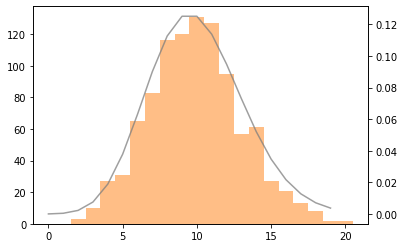

In [3]:
# Settings
lam = 2.0
s = 5.0
iters = 1000

# Create distribution
poisson = Poisson(lam, homogeneous=True)

# Sample number of events
sample = np.zeros(iters, dtype=np.int64)
for i in range(iters):
    sample[i] = poisson.events(s)
    
# Get probabilities of events samples
n_range = np.arange(2*lam*s)
probs = poisson.P(n=n_range, s=s)

# Print results
print('Expected mean: %.5f' % (lam*s))
print('Actual mean: %.5f' % (np.mean(sample)))
print('Expected std: %.5f' % ((lam*s)**0.5))
print('Actual std: %.5f' % (np.std(sample)))

# Plot results
fig, ax = plt.subplots()
ax.hist(sample, bins=np.arange(np.max(sample))+0.5, color='C1', alpha=0.5)
ax2 = ax.twinx()
ax2.plot(n_range, probs, color='C7', alpha=0.75);

### Search parameter space
It might be best to solve for the optimal foraging behavior (e.g. residence time) given a specified environment (e.g. travel time, cumulative reward function). Here, the cumulative reward function is actually based on a non-homogeneous Poisson process in the drip function.

Recall that a Poisson process is given by:
- exponentially distributed variables $t \mid p(t) = \lambda e^{-\lambda t}$
- a random variable $T \mid T_n = t_1 + t_2 + \ldots + t_n$
- a number of events $N \mid N(s) = max\{n \mid T_n \leq s\}$

The underlying statistics of such a process are:

$
\quad P(N(s) = n) = e^{-\lambda s} \frac{(\lambda s)^n}{n!} = Poisson(\lambda s) \\
\quad \mathbb{E}[N(s)] = \lambda s \\
\quad var[N(s)] = \lambda s
$

(We will use $p$ for probability density and $P$ for cumulative probability density. See Appendix for derivation of these statistics.)

When $\lambda$ is constant, the above is termed a *homogeneous* Poisson process. However, if $\lambda$ varies over time, then the process becomes *non-homogeneous* or *inhomogeneous*. In such cases, the process can be modeled as a homogeneous Poisson process over some interval $\left [ t_1, t_2 \right ]$ by replacing $\lambda$ with its integral over that time interval:

$
\quad \Lambda(t, s) = \int_t^{t+s} \lambda(t) dt \\
\quad P_t(N(s) = n) = e^{-\Lambda(t, s)} \frac{(\Lambda(t, s))^n}{n!} = Poisson(\Lambda(t, s)) \\
\quad \mathbb{E}_t[N(s)] = \Lambda(t, s) \\
\quad var_t[N(s)] = \Lambda(t, s)
$

(See Appendix for derivations.)

Given that drip times follow $T \sim Poisson(\Lambda(t, s))$, the mean drip rate is $\frac{\mathbb{E}[N(s)]}{s} = \frac{\Lambda(t, s)}{s}$ (or conversely, the mean inter-drip time is given by $\mathbb{E}_t (t_i - t_{i-1}) = \frac{1}{\Lambda(t, s)}$). The instantaneous fill rate of the bucket is then $\frac{dV}{dt} = lim_{s \to 0} \left ( V_{drip} \Lambda(t, s) \right ) = V_{drip} \lambda(t)$, and the cumulative reward function since time $t$ is:

$
\begin{align}
\quad V 
&= V_{drip} \mathbb{E}_t[N(s)] \\
&= V_{drip} \Lambda(t, s) \\
&= V_{drip} \int_t^{t+s} \lambda(t') dt'
\end{align}
$

In this case, $\lambda(t)$ decays over time:

$\quad \lambda(t) = \lambda_0 e^{-\frac{t}{\tau}}$

So the cumulative reward functions becomes:

$
\begin{align}
\quad V &= V_{drip} \int_t^{t+s} \lambda_0 e^{-\frac{t'}{\tau}} dt' \\
&= \lambda_0 V_{drip} \int_t^{t+s} e^{-\frac{t'}{\tau}} dt' \\
&= \lambda_0 V_{drip} \tau \left ( e^{-\frac{t}{\tau}} - e^{-\frac{t+s}{\tau}} \right )
\end{align}
$

or if $t=0$:

$
\begin{align}
\quad V &= \lambda_0 V_{drip} \tau \left ( 1 - e^{-\frac{s}{\tau}} \right )
\end{align}
$

Looking at the solution to the marginal value theorem for an exponentially decaying reward rate, we see that, on average, the Poisson drip model is in fact equivalent, with $r_0 = \lambda_0 V_{drip}$. Thus searching for parameters in this model amounts to finding the right parameters in the deterministic model ($r_0, R_0, \tau$), and then tuning the Poisson model parameters ($\lambda_0, V_{drip}$) within the constraint that $\lambda_0 V_{drip} = r_0$. While the expected cumulative reward per patch will remain the same, the variance of the cumulative reward per patch will vary as $\lambda_0 V^2_{drip}$: 

$
\begin{align}
\quad \mathbb{E}_t[V(s)] 
&= \mathbb{E}_t[V_{drip} N(s)] \\
&= V_{drip} \mathbb{E}_t[N(s)] \\
&= V_{drip} \Lambda(t, s) \\
\end{align}
$

$
\begin{align}
\quad var_t[V(s)] 
&= var_t[V_{drip} N(s)] \\
&= \mathbb{E}_t[(V_{drip} N(s))^2] - \left ( \mathbb{E}_t[V_{drip} N(s)] \right )^2 \\
&= V^2_{drip} \mathbb{E}_t[(N(s))^2] - \left ( V_{drip} \mathbb{E}_t[N(s)] \right )^2 \\
&= V^2_{drip} \left ( \mathbb{E}_t[(N(s))^2] - \left (\mathbb{E}_t[N(s)] \right)^2 \right ) \\
&= V^2_{drip} \Lambda(t, s)
\end{align}
$

(See the Appendix for another proof of the variance.)

Therefore, after finding the right point in parameter space for the deterministic model, the degree of stochasticity can be tuned by varying the product $\lambda_0 V_{drip}$ such that:

$
\quad \tau = \tau_{exp} = \tau_{Poisson} \\
\quad r_0 = V_{drip} \lambda_0 \\
\quad var_{t=0}[V(\infty)] = \sigma^2_V = V^2_{drip} \lambda_0 \tau \\
\quad \Rightarrow V^2_{drip} \left ( \dfrac{r_0}{V_{drip}} \right ) \tau = \sigma^2_V \\
\quad \Rightarrow V_{drip} = \dfrac{\sigma^2_V}{r_0 \tau} \\
\quad \Rightarrow \lambda_0 = \dfrac{r^2_0 \tau}{\sigma^2_V}
$

## Patch modeling

### Settings

In [10]:
# Settings
lam_drip_0 = 1.0 # initial drip parameter
lam_lick = 1.0/5.0 # lick parameter
lick_timeout = 1.0 # minimum time between rewarded licks
tau = 30.0 # rate of decay of lambda
V_drip = 2.0 # drip volume (uL)
V_reward = 2.0 # reward volume (uL)
t_0 = 0 # initial time (s)
s = 300 # end time (s)
num_patches = 1000

# Poisson parameter functions for drip process
lam_drip = lambda t: lam_drip_0*np.exp(-t/tau) # lambda(t)
Lam_drip = lambda t, s: lam_drip_0*tau*(np.exp(-t/tau) - np.exp(-(t+s)/tau)) # integral

### Method 1: Generate inter-reward intervals
I think this is actually the wrong way to do it!

#### Single patch

In [17]:
# Create initial distribution
mouse = Poisson(lam_lick)
drip = Poisson(lam_drip)

# Placeholders (for debugging)
t_drip = [] # drip times
t_lick = [] # lick times
t_event = []
V_bucket = [] # bucket volume

# Initialize variables
bucket = 0.0 # volume in bucket
t, t_next_drip, t_next_lick = t_0, t_0, t_0
t_prev_reward = -lick_timeout

while (t <= t_0 + s):
    # Increment timer to next event
    t = min(t_next_drip, t_next_lick)
    
    # Update Poisson params
    lam = lam_drip(t)
    drip.lam = lambda t: lam
    drip.Lam = lambda t, s: lam*s
    
    # Handle drip event
    if (t == t_next_drip):
        bucket += V_drip
        t_drip.append(t)
        t_next_drip = t + drip.times(t_max=100.0)
    
    # Handle lick event
    if (t == t_next_lick):
        if (bucket >= V_reward) and (t - t_prev_reward > lick_timeout):
            bucket -= V_reward
            t_prev_reward = t
        t_lick.append(t)
        t_next_lick = t + mouse.times(t_max=100.0)
        
    # Log bucket volume
    t_event.append(t)
    V_bucket.append(bucket)
    
# Create arrays
t_drip = np.array(t_drip)
t_lick = np.array(t_lick)
t_event = np.array(t_event)
V_bucket = np.array(V_bucket)

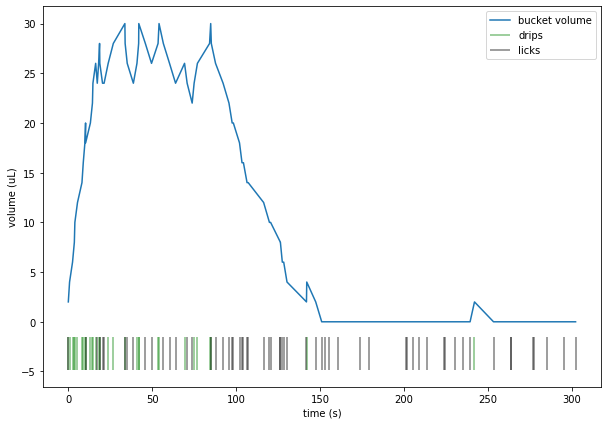

In [18]:
# Plot results
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(t_event, V_bucket, label='bucket volume')
ymin = ax.get_ylim()[0] - 0.1*np.diff(ax.get_ylim())
ymax = ax.get_ylim()[0]
ax.vlines(t_drip, ymin=ymin, ymax=ymax, color='green', alpha=0.5, label='drips')
ax.vlines(t_lick, ymin=ymin, ymax=ymax, color='black', alpha=0.5, label='licks')
ax.set_xlabel('time (s)')
ax.set_ylabel('volume (uL)')
ax.legend();

#### Multiple patches

In [23]:
# Create distributions
drip = Poisson(lam_drip)
mouse = Poisson(lam_lick)

# Placeholders
t_drip_all = []
t_lick_all = []
t_event_all = []
V_bucket_all = []

for patch in range(num_patches):
    # Initialize variables
    bucket = 0.0 # volume in bucket
    t, t_next_drip, t_next_lick = t_0, t_0, t_0
    t_prev_reward = -lick_timeout

    # Placeholders (for debugging)
    t_drip = [] # drip times
    t_lick = [] # lick times
    t_event = []
    V_bucket = [] # bucket volume

    while (t <= t_0 + s):
        # Update Poisson params
        lam = lam_drip(t)
        drip.lam = lambda t: lam
        drip.Lam = lambda t, s: lam*s

        # Handle drip event
        if (t == t_next_drip):
            bucket += V_drip
            t_drip.append(t)
            t_next_drip = t + drip.times(t_max=100.0)

        # Handle lick event
        if (t == t_next_lick):
            if (bucket >= V_reward) and (t - t_prev_reward > lick_timeout):
                bucket -= V_reward
                t_prev_reward = t
            t_lick.append(t)
            t_next_lick = t + mouse.times(t_max=100.0)

        # Log bucket volume
        t_event.append(t)
        V_bucket.append(bucket)
        
        # Increment timer to next event
        t = min(t_next_drip, t_next_lick)
    
    # Log simulation
    t_drip_all.append(np.array(t_drip))
    t_lick_all.append(np.array(t_lick))
    t_event_all.append(np.array(t_event))
    V_bucket_all.append(np.array(V_bucket))

Number of drips from t=0.00 s to t=300.00 s:
	Expected mean: 29.99864
	Actual mean: 35.96100
	Expected std: 5.47710
	Actual std: 5.39402


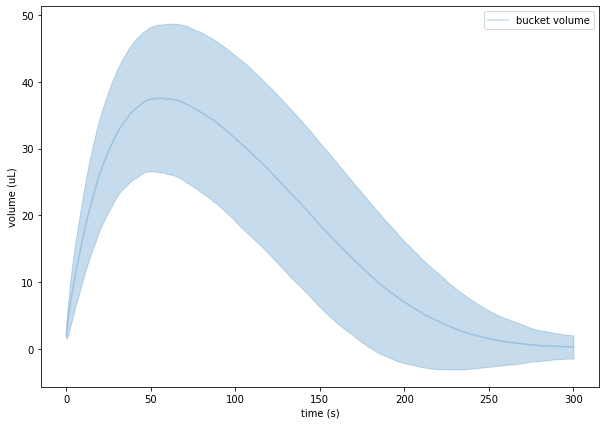

In [24]:
# Check mean and variance of N(s)
N_s = np.zeros([num_patches])
for i in range(num_patches):
    N_s[i] = len(t_drip_all[i])
    
# Print results of N(s)
print('Number of drips from t=%.2f s to t=%.2f s:' % (t_0, s))
print('\tExpected mean: %.5f' % (Lam_drip(t_0, s)))
print('\tActual mean: %.5f' % (np.mean(N_s)))
print('\tExpected std: %.5f' % ((Lam_drip(t_0, s))**0.5))
print('\tActual std: %.5f' % (np.std(N_s)))

# Interpolate for plotting purposes
t_interp = np.linspace(t_0, t_0 + s, num=10*s)
V_interp = np.zeros([num_patches, t_interp.size])
for i in range(num_patches):
    F = interp1d(t_event_all[i], V_bucket_all[i])
    idx_max = np.argwhere(t_interp <= t_event_all[i][-1]).flatten()[-1]
    V_interp[i, :idx_max+1] = F(t_interp[:idx_max+1])
    V_interp[i, idx_max+1:] = F(t_interp[idx_max])

# Plot results
fig, ax = plt.subplots(figsize=(10, 7))
mean = np.mean(V_interp, axis=0)
std = np.std(V_interp, axis=0)
ax.plot(t_interp, mean, color='C0', alpha=0.25, label='bucket volume')
ax.fill_between(t_interp, y1=mean-std, y2=mean+std, color='C0', alpha=0.25)
ax.set_xlabel('time (s)')
ax.set_ylabel('volume (uL)')
ax.legend();

### Method 2: Generate event times and prune
The correct way to generate inhomogeneous Poisson processes.

#### Single patch

In [19]:
# Create distributions
drip = Poisson(lam=lam_drip, Lam=Lam_drip, homogeneous=False)
mouse = Poisson(lam_lick)

# Get drip and lick events
t_drip = drip.times(interevent=False, t=0, s=s, t_max=100)
t_lick = mouse.times(interevent=False, t=0, s=s)

# Placeholders (for debugging)
t_event = []
V_bucket = [] # bucket volume

# There should be a vectorized way to do this...
bucket = 0.0 # volume in bucket
t = t_0
idx_drip = 0
idx_lick = 0
t_prev_reward = -lick_timeout
while (True): 
    # Determine event type
    if (idx_drip < t_drip.size) and (idx_lick < t_lick.size):
        is_drip = (t_drip[idx_drip] < t_lick[idx_lick])
    elif (idx_drip < t_drip.size) and (idx_lick == t_lick.size):
        is_drip = True
    elif (idx_drip == t_drip.size) and (idx_lick < t_lick.size):
        is_drip = False
    else:
        break
    
    # Handle drip event
    if is_drip:
        t = t_drip[idx_drip]
        bucket += V_drip
        idx_drip += 1
    
    # Handle lick event
    else:
        t = t_lick[idx_lick]
        if (bucket >= V_reward) and (t - t_prev_reward > lick_timeout):
            bucket -= V_reward
            t_prev_reward = t
        idx_lick += 1
        
    # Log bucket volume
    t_event.append(t)
    V_bucket.append(bucket)
    
# Create arrays
t_event = np.array(t_event)
V_bucket = np.array(V_bucket)

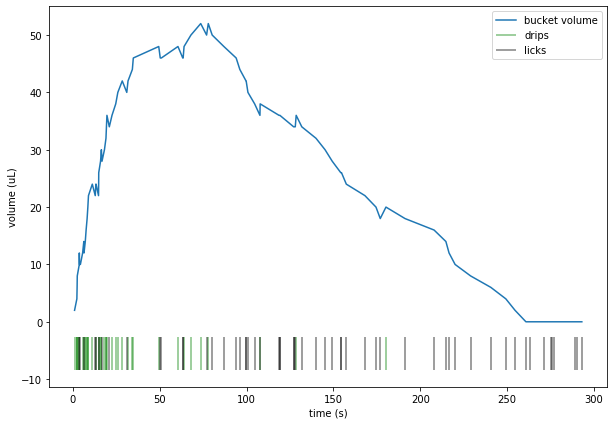

In [20]:
# Plot results
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(t_event, V_bucket, label='bucket volume')
ymin = ax.get_ylim()[0] - 0.1*np.diff(ax.get_ylim())
ymax = ax.get_ylim()[0]
ax.vlines(t_drip, ymin=ymin, ymax=ymax, color='green', alpha=0.5, label='drips')
ax.vlines(t_lick, ymin=ymin, ymax=ymax, color='black', alpha=0.5, label='licks')
ax.set_xlabel('time (s)')
ax.set_ylabel('volume (uL)')
ax.legend();

#### Multiple patches

In [21]:
# Create distributions
drip = Poisson(lam=lam_drip, Lam=Lam_drip, homogeneous=False)
mouse = Poisson(lam_lick)

# Placeholders
t_drip_all = []
t_lick_all = []
t_event_all = []
V_bucket_all = []

for patch in range(num_patches):
    # Initialize variables
    t = t_0 # current time (s)
    bucket = 0.0 # volume in bucket

    # Get drip and lick events
    t_drip = drip.times(interevent=False, t=t_0, s=s, t_max=100)
    t_lick = mouse.times(interevent=False, t=t_0, s=s)

    # Placeholders (for debugging)
    t_event = []
    V_bucket = [] # bucket volume

    # There should be a vectorized way to do this...
    idx_drip = 0
    idx_lick = 0
    t_prev_reward = -lick_timeout
    while (True): 
        # Determine event type
        if (idx_drip < t_drip.size) and (idx_lick < t_lick.size):
            is_drip = (t_drip[idx_drip] < t_lick[idx_lick])
        elif (idx_drip < t_drip.size) and (idx_lick == t_lick.size):
            is_drip = True
        elif (idx_drip == t_drip.size) and (idx_lick < t_lick.size):
            is_drip = False
        else:
            break

        # Handle drip event
        if is_drip:
            t = t_drip[idx_drip]
            bucket += V_drip
            idx_drip += 1

        # Handle lick event
        else:
            t = t_lick[idx_lick]
            if (bucket >= V_reward) and (t - t_prev_reward > lick_timeout):
                bucket -= V_reward
                t_prev_reward = t
            idx_lick += 1

        # Log bucket volume
        t_event.append(t)
        V_bucket.append(bucket)

    # Log simulation
    t_drip_all.append(t_drip)
    t_lick_all.append(t_lick)
    t_event_all.append(np.array(t_event))
    V_bucket_all.append(np.array(V_bucket))

Number of drips from t=0.00 s to t=300.00 s:
	Expected mean: 29.99864
	Actual mean: 29.85500
	Expected std: 5.47710
	Actual std: 5.24900


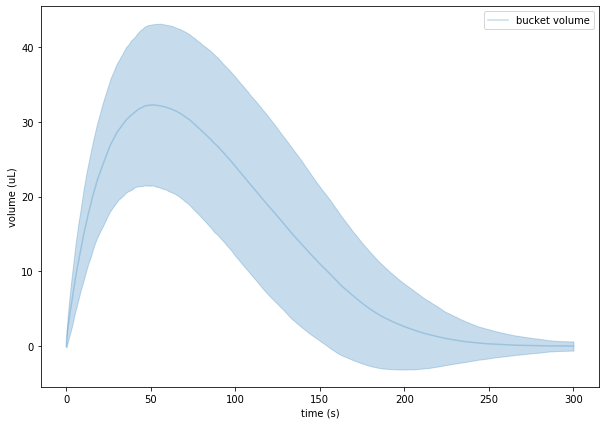

In [22]:
# Check mean and variance of N(s)
N_s = np.zeros([num_patches])
for i in range(num_patches):
    N_s[i] = len(t_drip_all[i])
    
# Print results of N(s)
print('Number of drips from t=%.2f s to t=%.2f s:' % (t_0, s))
print('\tExpected mean: %.5f' % (Lam_drip(t_0, s)))
print('\tActual mean: %.5f' % (np.mean(N_s)))
print('\tExpected std: %.5f' % ((Lam_drip(t_0, s))**0.5))
print('\tActual std: %.5f' % (np.std(N_s)))

# Interpolate for plotting purposes
t_interp = np.linspace(t_0, t_0 + s, num=10*s)
V_interp = np.zeros([num_patches, t_interp.size])
for i in range(num_patches):
    F = interp1d(np.insert(t_event_all[i], 0, 0.0), 
                 np.insert(V_bucket_all[i], 0, 0.0))
    idx_max = np.argwhere(t_interp <= t_event_all[i][-1]).flatten()[-1]
    V_interp[i, :idx_max+1] = F(t_interp[:idx_max+1])
    V_interp[i, idx_max+1:] = F(t_interp[idx_max])

# Plot results
fig, ax = plt.subplots(figsize=(10, 7))
mean = np.mean(V_interp, axis=0)
std = np.std(V_interp, axis=0)
ax.plot(t_interp, mean, color='C0', alpha=0.25, label='bucket volume')
ax.fill_between(t_interp, y1=mean-std, y2=mean+std, color='C0', alpha=0.25)
ax.set_xlabel('time (s)')
ax.set_ylabel('volume (uL)')
ax.legend();

This looks right. In the first method, the mean is too long.

## Expectation of waiting time
For a non-homogeneous Poisson process, what is the expected waiting time to the first event (after some time $t$)? For derivations of the probability distribution functions and expected wait times, see *Expected Reward Times* in *Appendix*.

### Probability distribution functions

In [2]:
# Settings
lam0 = 2.5 # initial Poisson rate
tau = 6.0 # decay rate
lam = lambda t: lam0*np.exp(-t/tau)
Lam = lambda t, s: lam0*tau*(np.exp(-t/tau) - np.exp(-(t+s)/tau))

In [3]:
# Define probability functions for nth event occuring within [t, t+s]
P = lambda t, s, n: np.exp(-Lam(t,s))*(Lam(t,s)**n)/factorial(n)
p = lambda t, s, n: (1.0/factorial(n))*np.exp(-Lam(t,s))*lam(t+s)*(Lam(t,s)**(n-1))*(Lam(t,s) - n)

# Define probability functions for nth event occuring at time t
F = lambda t, s, N: 1.0 - np.sum(np.exp(-Lam(t, s))*np.power(Lam(t, s), np.arange(N))/factorial(np.arange(N)), axis=1)
f = lambda t, s, N: np.sum((1.0/factorial(np.arange(N)))*lam(t+s)*np.power(Lam(t, s), np.arange(N)-1)
                           *np.exp(-Lam(t, s))*(Lam(t, s) - np.arange(N)), axis=1)

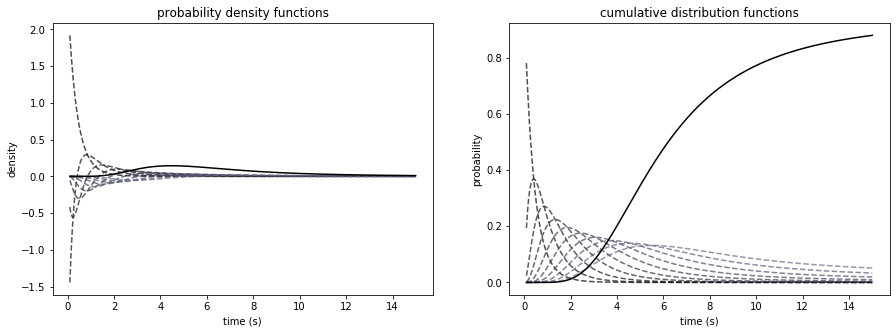

In [4]:
# Plot probability distribution
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
cmap = plt.get_cmap('bone')
t0 = 0.0
s = np.linspace(0.1, 15.0, num=1000).reshape([-1, 1])

# Plot probability density function
N = 10
for n in range(N):
    ax[0].plot(t0 + s,
               p(t0, s, n),
               color=cmap(0.5*n/N),
               linestyle='--',
               alpha=0.7)
ax[0].plot(t0 + s,
           f(t0, s, N),
           color=cmap(0.0),
           linestyle='-')
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('density')
ax[0].set_title('probability density functions')

# Plot cumulative distribution function
N = 10
for n in range(N):
    ax[1].plot(t0 + s,
               P(t0, s, n),
               color=cmap(0.5*n/N),
               linestyle='--',
               alpha=0.7)
ax[1].plot(t0 + s,
           F(t0, s, N),
           color=cmap(0.0),
           linestyle='-')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('probability')
ax[1].set_title('cumulative distribution functions');

Interestingly, the probability density functions essentially cancel out the peaks of the *pdf*s for prior events, pushing the peak for the $n^{th}$ event outward in time. Notice also how the *cdf* may not approach unity even in the limit that $t \rightarrow \infty$. Because the Poisson rate is exponentially decaying in time, there can be event sequences that never reach the $N^{th}$ event; for instance, the expected value of number of observations after some time $t$, $\Lambda(t, \infty)$ may be less than the number of observations need to reach event $N$. Thus, the value of $F(\infty)$ represents the probability that the sequence will have an $N^{th}$ event.

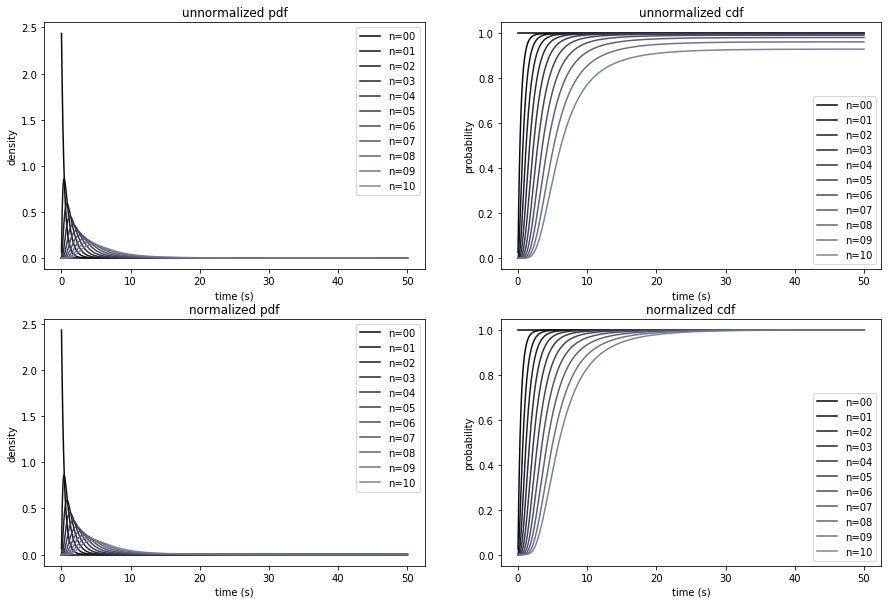

In [7]:
# Settings
t0 = np.array([[0.0]])
s = np.linspace(0.01, 50.0, num=1000).reshape([-1, 1])
N = 10

# Create figure
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
cmap = plt.get_cmap('bone')

for n in np.arange(N+1):
    # Plot unnormalized probability density
    ax[0, 0].plot(t0 + s, 
                  f(t0, s, n),
                  color=cmap(0.5*n/N),
                  alpha=F(t0, 1000.0, n),
                  label='n={:02d}'.format(n))
    ax[0, 0].set_title('unnormalized pdf')
    ax[0, 0].set_ylabel('density')
    
    # Plot normalized probability density
    ax[1, 0].plot(t0 + s, 
                  f(t0, s, n)/F(t0, 1000.0, n),
                  color=cmap(0.5*n/N),
                  alpha=F(t0, 1000.0, n),
                  label='n={:02d}'.format(n))
    ax[1, 0].set_title('normalized pdf')
    ax[1, 0].set_ylabel('density')
    
    # Plot unnormalized cumulative probability
    ax[0, 1].plot(t0 + s, 
                  F(t0, s, n),
                  color=cmap(0.5*n/N),
                  alpha=F(t0, 1000.0, n),
                  label='n={:02d}'.format(n))
    ax[0, 1].set_title('unnormalized cdf')
    ax[0, 1].set_ylabel('probability')
    
    # Plot normalized cumulative probability
    ax[1, 1].plot(t0 + s, 
                  F(t0, s, n)/F(t0, 1000.0, n),
                  color=cmap(0.5*n/N),
                  alpha=F(t0, 1000.0, n),
                  label='n={:02d}'.format(n))
    ax[1, 1].set_title('normalized cdf')
    ax[1, 1].set_ylabel('probability')
    
    

# Label axes
for ax_ in ax.reshape(-1):
    ax_.set_xlabel('time (s)')
    ax_.legend();

### First event

In [8]:
# Model settings
lam0 = 2.5 # initial Poisson rate
tau = 6.0 # decay rate
lam = lambda t: lam0*np.exp(-t/tau)
Lam = lambda t, s: lam0*tau*(np.exp(-t/tau) - np.exp(-(t+s)/tau))
model = Poisson(lam=lam, Lam=Lam, homogeneous=False)

In [9]:
# Simulate events
t0 = 1.0 # start time
N = 1000 # number of simulations
t = np.zeros([N])
for n in range(N):
    t[n] = model.times(interevent=False, t=t0, s=1000.0)[0]

In [12]:
# Calculate expected waiting time. Note that we have to reverse the order of
# arguments since we're integrating over s, not t. Also, we need to pass the points
# parameters since the integrand is close to zero for most of t > 0.0:
# see https://stackoverflow.com/a/51053180
pts = np.geomspace(0.01, 1000.0, num=25)
g = lambda s, t: np.exp(-lam0*tau*(np.exp(-t/tau) - np.exp(-(t+s)/tau)))
f = lambda s, t: s*lam(t+s)*g(s, t)
t_est = integrate.quad(f, 0.0, 1000.0, args=(t0,), points=pts)[0]

# Print results
print('Expected mean time to first event: {:.3f}'.format(t_est))
print('Actual mean time to first event:  {:.3f}'.format(t.mean() - t0))

Expected mean time to first event: 0.518
Actual mean time to first event:  0.520


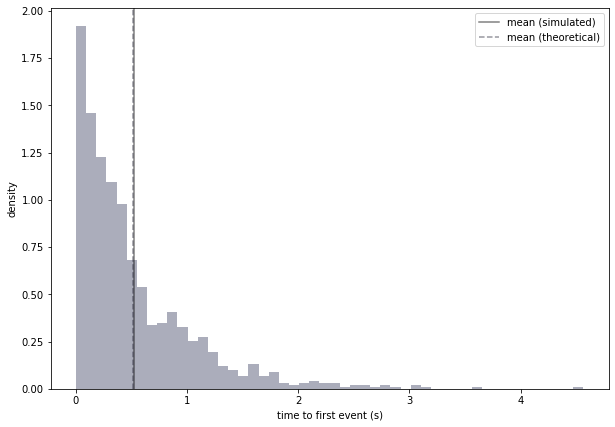

In [13]:
# Figure settings
fig, ax = plt.subplots(figsize=(10, 7))
cmap = plt.get_cmap('bone')

# Plot histogram of simulated values
ax.hist(t - t0, 
        color=cmap(0.4), 
        alpha=0.5,
        bins=50,
        density=True)
ax.axvline(t.mean() - t0, 
           color=cmap(0.0), 
           linestyle='-',
           alpha=0.5,
           label='mean (simulated)')

# Plot theoretical mean
ax.axvline(t_est, 
           color=cmap(0.2), 
           linestyle='--',
           alpha=0.5,
           label='mean (theoretical)')

# Label axes
ax.set_xlabel('time to first event (s)')
ax.set_ylabel('density')
ax.legend();

### Nth event

In [14]:
# Model settings
M = 10 # mth event to estimate waiting time
lam0 = 2.5 # initial Poisson rate
tau = 6.0 # decay rate
lam = lambda t: lam0*np.exp(-t/tau)
Lam = lambda t, s: lam0*tau*(np.exp(-t/tau) - np.exp(-(t+s)/tau))
model = Poisson(lam=lam, Lam=Lam, homogeneous=False)

In [15]:
# Simulate events
t0 = 3.0 # start time
N = 1000 # number of simulations
t = np.ones([N])*np.nan
for n in range(N):
    try:
        t[n] = model.times(interevent=False, t=t0, s=1000.0)[M-1]
    except IndexError:
        continue

In [16]:
# Determine probability of Mth event occurring in sequence
Lam_inf = lambda t: lam0*tau*np.exp(-t/tau) # Lam(t, inf)
F0 = lambda t, n: 1.0 - np.exp(-Lam_inf(t))*np.sum(np.power(Lam_inf(t), np.arange(n))
                                                   /factorial(np.arange(n)))

# Method 1: estimate by dividing rate by M
pts = np.geomspace(0.01, 1000.0, num=25)
g = lambda s, t: np.exp(-lam0/M*tau*(np.exp(-t/tau) - np.exp(-(t+s)/tau)))
h = lambda s, t: s*(lam(t+s)/M)*g(s, t)
t_est_1 = integrate.quad(h, 0.0, 1000.0, args=(t0,), points=pts)[0]
t_est_1 /= F0(t0, M)

# Method 2: compute the integral in two parts
# 1) N(t) = 0 component
# 2) N(t) = 1,...,N-1 component
h = lambda s, t, m: s*lam(t+s)*(Lam(t, s)**(m-1))*np.exp(-Lam(t, s))*(Lam(t, s) - m)
t_est_2 = 0.0
for m in range(M):
    t_est_2 += (1.0/factorial(m))*integrate.quad(h, 0.0, 1000.0, 
                                                 args=(t0, m), 
                                                 points=pts)[0]
t_est_2 /= F0(t0, M)

# Method 3: leave sum inside integral (for faster computation)
h = lambda s, t, m: s*np.sum((1.0/factorial(np.arange(m)))*lam(t+s)*np.power(Lam(t, s), np.arange(m)-1)
                             *np.exp(-Lam(t, s))*(Lam(t, s) - np.arange(m)))
t_est_3 = integrate.quad(h, 0.0, 1000.0, 
                         args=(t0, M), 
                         points=pts)[0]
t_est_3 /= F0(t0, M)

# Print results
print('Expected probability of observing Mth event: {:.3f}'.format(F0(t0, M)))
print('Actual probability of observing Mth event:   {:.3f}'.format(np.sum(~np.isnan(t))/t.shape[0]))
print()
print('Expected mean time to mth event (method 1): {:.3f}'.format(t_est_1))
print('Expected mean time to mth event (method 2): {:.3f}'.format(t_est_2))
print('Expected mean time to mth event (method 3): {:.3f}'.format(t_est_3))
print('Actual mean time to mth event:              {:.3f}'.format(np.nanmean(t) - t0))

Expected probability of observing Mth event: 0.425
Actual probability of observing Mth event:   0.396

Expected mean time to mth event (method 1): 6.625
Expected mean time to mth event (method 2): 11.624
Expected mean time to mth event (method 3): 11.624
Actual mean time to mth event:              11.433


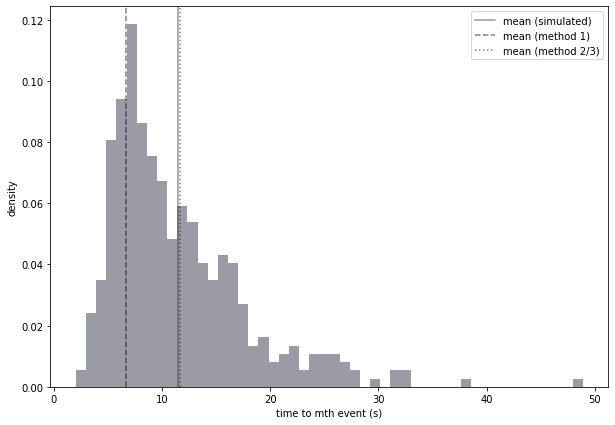

In [17]:
# Figure settings
fig, ax = plt.subplots(figsize=(10, 7))
cmap = plt.get_cmap('bone')

# Plot histogram of simulated values
ax.hist(t - t0, 
        color=cmap(0.25), 
        alpha=0.5,
        bins=50,
        density=True)
ax.axvline(np.nanmean(t) - t0, 
           color=cmap(0.2), 
           linestyle='-',
           alpha=0.5,
           label='mean (simulated)')

# Plot theoretical means
ax.axvline(t_est_1, 
           color=cmap(0.0), 
           linestyle='--',
           alpha=0.5,
           label='mean (method 1)')
ax.axvline(t_est_2, 
           color=cmap(0.0), 
           linestyle=':',
           alpha=0.5,
           label='mean (method 2/3)')

# Label axes
ax.set_xlabel('time to mth event (s)')
ax.set_ylabel('density')
ax.legend();

### Consecutive events
Is the summation of expected waiting times for consecutive events the same as the expected waiting time for the last event?

In [18]:
# Model settings
M = 10 # mth event to estimate waiting time
K = 10 # number of mth events to estimate
lam0 = 2.5*M # initial Poisson rate
tau = 6.0 # decay rate
lam = lambda t: lam0*np.exp(-t/tau)
Lam = lambda t, s: lam0*tau*(np.exp(-t/tau) - np.exp(-(t+s)/tau))
model = Poisson(lam=lam, Lam=Lam, homogeneous=False)

In [19]:
# Simulate events
t0 = 2.0 # start time
N = 1000 # number of simulations
t = np.ones([N, K])*np.nan
for n in range(N):
    try:
        t[n] = model.times(interevent=False, t=t0, s=1000.0)[np.array([(k+1)*M-1 for k in range(K)])]
    except IndexError:
        continue

In [20]:
# Determine probability of Mth event occurring in sequence
Lam_inf = lambda t: lam0*tau*np.exp(-t/tau) # Lam(t, inf)
F0 = lambda t, n: 1.0 - np.exp(-Lam_inf(t))*np.sum(np.power(Lam_inf(t), np.arange(n))
                                                   /factorial(np.arange(n)))

# Method 1: estimate each event time independently
pts = np.geomspace(0.01, 1000.0, num=25)
h = lambda s, t, m: s*np.sum((1.0/factorial(np.arange(m)))*lam(t+s)*np.power(Lam(t, s), np.arange(m)-1)
                             *np.exp(-Lam(t, s))*(Lam(t, s) - np.arange(m)))
t_est_1 = np.zeros([K])
for k in range(K):
    t_est_1[k] = integrate.quad(h, 0.0, 100.0, 
                                args=(t0, (k+1)*M), 
                                points=pts)[0]
    t_est_1[k] /= F0(t0, (k+1)*M)

# Method 2: estimate each event time from previous estimate
t_est_2 = np.zeros([K])
t_start = t0
for k in range(K):
    t_est_2[k] = integrate.quad(h, 0.0, 100.0, 
                                args=(t_start, M), 
                                points=pts)[0]
    t_est_2[k] /= F0(t0, M)
    t_start += t_est_2[k]
t_est_2 = np.cumsum(t_est_2)

# Print results
print('Expected probability of observing K*Mth event: {:.3f}'.format(F0(t0, M*K)))
print('Actual probability of observing K*Mth event:   {:.3f}'.format(np.sum(~np.isnan(t[:,-1]))/t.shape[0]))
print()
print('Expected mean time to events (method 1): {}'.format(', '.join(['{:.3f}'.format(tk) for tk in t_est_1])))
print('Expected mean time to events (method 2): {}'.format(', '.join(['{:.3f}'.format(tk) for tk in t_est_2])))
print('Actual mean time to events:              {}'.format(', '.join(['{:.3f}'.format(tk - t0) for tk in np.nanmean(t, axis=0)])))

Expected probability of observing K*Mth event: 0.777
Actual probability of observing K*Mth event:   0.796

Expected mean time to events (method 1): 0.589, 1.243, 1.979, 2.820, 3.803, 4.988, 6.493, 8.576, 11.603, 15.285
Expected mean time to events (method 2): 0.589, 1.243, 1.977, 2.815, 3.791, 4.959, 6.417, 8.359, 11.304, 17.309
Actual mean time to events:              0.575, 1.192, 1.883, 2.669, 3.564, 4.644, 5.953, 7.668, 10.161, 15.207


## Appendix

### Homogeneous Poisson process
The mean and variance of a homogeneous Poisson process (that is, $\lambda(t) = k \: \forall \: t$) are given by:

$
\begin{align}
\quad \mathbb{E}[N(s)] 
&= \sum_{n=0}^{\infty} n \cdot P(N(s) = n) \\
&= 0 + \sum_{n=1}^{\infty} n \cdot P(N(s) = n) \\
&= \sum_{n=1}^{\infty} n e^{-\lambda s} \frac{(\lambda s)^n}{n!} \\
&= \sum_{n=1}^{\infty} e^{-\lambda s} \frac{(\lambda s)^n}{(n-1)!} \\
&= (\lambda s) (e^{-\lambda s}) \sum_{n=1}^{\infty} \frac{(\lambda s)^{n-1}}{(n-1)!} \\
&= (\lambda s) (e^{-\lambda s}) (e^{\lambda s}) \\
&= \lambda s
\end{align}
$

$
\begin{align}
\quad \mathbb{E}[\left ( N(s) \right ) \left ( N(s) - 1 \right )]
&= \sum_{n=0}^{\infty} n(n-1) \cdot P(N(s) = n) \\
&= 0 + 0 + \sum_{n=2}^{\infty} n(n-1) e^{-\lambda s} \frac{(\lambda s)^n}{n!} \\
&= \sum_{n=2}^{\infty} e^{-\lambda s} \frac{(\lambda s)^n}{(n-2)!} \\
&= (\lambda s)^2 (e^{-\lambda s}) \sum_{n=2}^{\infty} \frac{(\lambda s)^{n-2}}{(n-2)!} \\
&= (\lambda s)^2 (e^{-\lambda s}) (e^{\lambda s}) \\
&= (\lambda s)^2
\end{align}
$

$
\begin{align}
\quad var[N(s)]
&= \mathbb{E}[(N(s))^2] - \left ( \mathbb{E}[N(s)] \right )^2 \\
&= \mathbb{E}[(N(s))^2] - \mathbb{E}[N(s)] + \mathbb{E}[N(s)] - \left ( \mathbb{E}[N(s)] \right )^2 \\
&= \mathbb{E}[(N(s))^2 - N(s)] + \mathbb{E}[N(s)] - \left ( \mathbb{E}[N(s)] \right )^2 \\
&= \mathbb{E}[(N(s))(N(s) - 1)] + \mathbb{E}[N(s)] - \left ( \mathbb{E}[N(s)] \right )^2 \\
&= (\lambda s)^2 + \lambda s - (\lambda s)^2 \\
&= \lambda s
\end{align}
$

where we used the Taylor expansion $e^x = \sum_{n=0}^{\infty} \frac{x^n}{n!}$ in the infinite sums.

### Non-homogeneous Poisson process

When I try to apply this to a non-homogeneous process with parameter $\lambda(t)$ that is dependent on $t$, I get the mean:

$
\begin{align}
\quad \mathbb{E}[N(s)] 
&= \lim_{\delta r \to 0} \sum_{r=0}^s \left ( \sum_{n=0}^{\infty} n \cdot P(N_r(\delta r) = n) \right ) \\
&= \int_0^s \left ( \sum_{n=0}^{\infty} n \cdot P(N_r(\delta r) = n) \right ) \\
&= \int_0^s \left ( \sum_{n=1}^{\infty} n e^{-\lambda(r) dr} \frac{(\lambda(r) dr)^n}{n!} \right ) \\
&= \int_0^s \left ( \lambda(r) dr \sum_{n=1}^{\infty} e^{-\lambda(r) dr} \frac{(\lambda(r) dr)^{n-1}}{(n-1)!} \right ) \\
&= \int_0^s \left ( \lambda(r) dr \right ) \left ( e^{-\lambda(r) dr} \right ) \left ( e^{\lambda(r) dr} \right ) \\
&= \int_0^s \lambda(r) dr \\
&= \Lambda(t, s)
\end{align}
$

But when I try to derive the $\mathbb{E}[\left ( N(s) \right ) \left ( N(s) - 1 \right )]$ term, I get stuck:

$
\begin{align}
\quad \mathbb{E}[\left ( N(s) \right ) \left ( N(s) - 1 \right )]
&= \int_0^s \left ( \sum_{n=0}^{\infty} n(n-1) \cdot P(N_r(dr) = n) \right ) \\
&= \int_0^s \left ( \sum_{n=2}^{\infty} n(n-1) e^{-\lambda(r) dr} \frac{(\lambda(r) dr)^n}{n!} \right ) \\
&= \int_0^s \left ( \left ( \lambda(r) dr \right )^2 e^{-\lambda(r) dr} \sum_{n=2}^{\infty} \frac{(\lambda(r) dr)^{n-2}}{(n-2)!} \right ) \\
&= \int_0^s \left ( \left ( \lambda(r) dr \right )^2 \left ( e^{-\lambda(r) dr}  \right ) \left ( e^{-\lambda(r) dr} \right ) \right ) \\
&= \int_0^s \left ( \lambda(r) dr \right )^2 \\
&=^? \left ( \int_0^s \lambda(r) dr \right )^2
\end{align}
$

Edit: [This answer](https://math.stackexchange.com/a/3293876/695405) to a similar question may be relevant.

Edit: This has been answered on [StackExchange](https://math.stackexchange.com/a/3501155/695405).

### Variance of a scaled Poisson process
If we scale a (non-homogeneous) Poisson process by some constant $k$, such that we track a variable $M_t(s) = k N_t(s)$, then the mean and variance should be scaled by $k$ and $k^2$, respectively:

$
\begin{align}
\quad \mathbb{E}_t[M(s)] 
&= \mathbb{E}_t[k N(s)] \\
&= k \mathbb{E}_t[N(s)] \\
&= k \Lambda(t, s) \\
\end{align}
$

$
\begin{align}
\quad var_t[M(s)] 
&= var_t[k N(s)] \\
&= \mathbb{E}_t[(k N(s))^2] - \left ( \mathbb{E}_t[k N(s)] \right )^2 \\
&= \mathbb{E}_t[(k N(s))^2] - \mathbb{E}_t[k^2 N(s)] + \mathbb{E}_t[k^2 N(s)] - \left ( \mathbb{E}_t[k N(s)] \right )^2 \\
&= \mathbb{E}_t[(k N(s))^2 - k^2 N(s)] + \mathbb{E}_t[k^2 N(s)] - \left ( \mathbb{E}_t[k N(s)] \right )^2 \\
&= k^2 \mathbb{E}_t[N(s) (N(s)-1)] + k^2 \mathbb{E}_t[N(s)] - k^2 \left ( \mathbb{E}_t[N(s)] \right )^2 \\
&= k^2 \left ( \Lambda(t, s) \right )^2 + k^2 \Lambda(t, s) - k^2 \left ( \Lambda(t, s) \right )^2 \quad \text{(given proof above)} \\
&= k^2 \Lambda(t, s)
\end{align}
$

### Expected reward times
Given a time $t$, what are the expected times for rewards $\{T_1, \ldots, T_N\}$ in the future? To start, let's calculate the cumulative distribution function (cdf) for the time of the $N^{th}$ event given that the current time is $t$. We will use the transformation $S_N = T_N - t$ and $s = t' - t$ for ease of calculation.

$
\begin{align}
\quad F_{S_N}(s; t) 
&= P(S_N \leq s; t) \\
&= 1 - P(S_n > s; t) \\
&= 1 - \sum_{n=0}^{N-1} P(N(s) = n; t) \\
&= 1 - \sum_{n=0}^{N-1} \left ( e^{-\Lambda(t,s)} \left ( \dfrac{\Lambda(t,s)^n}{n!} \right ) \right )
\end{align}
$

where

$
\quad \Lambda(t,s) = \int_{t}^{t+s} \lambda(s')ds'
$

Next, we compute the probability density function (pdf) by taking the derivative of the cdf:

$
\begin{align}
\quad f_{S_N}(s; t)
&= \dfrac{d F_{S_N}(s; t)}{ds} \\
&= \dfrac{d}{ds} \left ( 1 - \sum_{n=0}^{N-1} e^{-\Lambda(t,s)} \dfrac{\Lambda(t,s)^n}{n!} \right ) \\
&= -\dfrac{d}{ds} \left ( \sum_{n=0}^{N-1} e^{-\Lambda(t,s)} \dfrac{\Lambda(t,s)^n}{n!} \right ) \\
&= -\sum_{n=0}^{N-1} \dfrac{d}{ds} \left ( e^{-\Lambda(t,s)} \dfrac{\Lambda(t,s)^n}{n!} \right ) \\
&= -\sum_{n=0}^{N-1} \dfrac{1}{n!} \dfrac{d}{ds} \left ( e^{-\Lambda(t,s)} \Lambda(t,s)^n \right ) \\
&= -\sum_{n=0}^{N-1} \dfrac{1}{n!} \Big [ \left ( -\lambda(t+s) e^{-\Lambda(t,s)} \right ) \Lambda(t,s)^n
+ e^{-\Lambda(t,s)} \left ( n \Lambda(t,s)^{n-1} \lambda(t+s) \right ) \Big ] \\
&= \sum_{n=0}^{N-1} \dfrac{1}{n!} \Big [ e^{-\Lambda(t,s)} \lambda(t+s) \Lambda(t,s)^{n-1}
\left ( \Lambda(t,s) - n \right ) \Big ] \\
\end{align}
$

where

$
\quad \dfrac{d \Lambda(t,s)}{ds} 
= \dfrac{d}{ds} \left ( \int_{t}^{t+s} \lambda(s')ds' \right )
= \lambda(t+s)
$

by the Fundamental Theorem of Calculus (note the importance of the limit in the definite integral). When we check the criteria for a valid probability density function (or cumulative distribution function), however, we run into a problem: $\lim_{s \rightarrow \infty} (F_{S_N}(s; t)) < 1$, or equivalently $\int_t^\infty f_{S_N}(s'; t) ds' < 1$. We can see that this is the case because:

$\begin{align}
\quad \lim_{s \rightarrow \infty} (F_{S_N}(s; t))
&= \lim_{s \rightarrow \infty} \left ( 1 - \sum_{n=0}^{N-1} e^{-\Lambda(t,s)} \dfrac{\Lambda(t,s)^n}{n!} \right ) \\
&= 1 - \lim_{s \rightarrow \infty} \left ( \sum_{n=0}^{N-1} e^{-\Lambda(t,s)} \dfrac{\Lambda(t,s)^n}{n!} \right ) \\
&= 1 - \sum_{n=0}^{N-1} \dfrac{1}{n!} \lim_{s \rightarrow \infty} \left ( e^{-\Lambda(t,s)} \Lambda(t,s)^n \right ) \\
&= 1 - \sum_{n=0}^{N-1} \dfrac{1}{n!} \left ( e^{-a} a^n \right )
\end{align}
$

where 

$\begin{align}
\quad a 
&= \Lambda(t,\infty) \\
&= \int_{t}^{\infty} \lambda(s')ds' \\
&= -\lambda_0 \tau \left ( e^{-\frac{s}{\tau}} \right ) \bigg |^{\infty}_{t} \\
&= -\lambda_0 \tau \left ( 0 - e^{-\frac{t}{\tau}} \right ) \\
&= \lambda_0 \tau e^{-\frac{t}{\tau}}
\end{align}
$

We can rewrite the summation term as:

$\begin{align}
\quad \sum_{n=0}^{N-1} \dfrac{1}{n!} \left ( e^{-a} a^n \right )
&= e^{-a} \sum_{n=0}^{N-1} \dfrac{a^n}{n!} \\
&= e^{-a} \left ( \sum_{n=0}^{\infty} \dfrac{a^n}{n!} - \sum_{n=N}^{\infty} \dfrac{a^n}{n!} \right ) \\
&= e^{-a} \left ( e^a - \sum_{n=N}^{\infty} \dfrac{a^n}{n!} \right ) \\
&= 1 - \dfrac{\sum_{n=N}^{\infty} \dfrac{a^n}{n!}}{e^{a}}
\end{align}
$

Plugging this back into our original equation:

$
\begin{align}
\quad \lim_{s \rightarrow \infty} (F_{S_N}(s; t))
&= 1 - \sum_{n=0}^{N-1} \dfrac{1}{n!} \left ( e^{-a} a^n \right ) \\
&= 1 - \left ( 1 - \dfrac{\sum_{n=N}^{\infty} \dfrac{a^n}{n!}}{e^{a}} \right ) \\
&= \dfrac{\sum_{n=N}^{\infty} \dfrac{a^n}{n!}}{e^{a}}
\end{align}
$

and observing the following inequality leads us to:

$
\quad \sum_{n=N}^{\infty} \dfrac{a^n}{n!} < \sum_{n=0}^{\infty} \dfrac{a^n}{n!} \\
\quad \Rightarrow \sum_{n=N}^{\infty} \dfrac{a^n}{n!} < e^a \\
\quad \Rightarrow \dfrac{\sum_{n=N}^{\infty} \dfrac{a^n}{n!}}{e^a} < 1 \\
\quad \Rightarrow \lim_{s \rightarrow \infty} (F_{S_N}(s; t)) < 1
$

Upon further thought, the inequality makes sense: because $\lim_{t \rightarrow \infty} \lambda(t) = 0$ and $\Lambda(t, \infty)$ is finite, individual sequences may never reach the $N^{th}$ event, particularly for large $N$ and/or large $t$. We can thus think of the cumulative distribution function as a factor of two components: 1) the probability of ever seeing the $N^{th}$ event for a given sequence, and 2) the probability of when that event would occur if it is observed.

$
\quad F_{S_N}(s; t)
= P(S_N < s; t) \dfrac{P(S_N < \infty; t)}{P(S_N < \infty; t)}
= \dfrac{P(S_N < s; t)}{P(S_N < \infty; t)} P(S_N < \infty; t)
= \tilde{F}_{S_N}(s; t) F_0
$

where 

$
\begin{align}
\quad F_0 
&= P(S_N < \infty; t) \\
&= 1 - \sum_{n=0}^{N-1} P(N(\infty) = n; t) \\
&= 1 - \sum_{n=0}^{N-1} e^{-\Lambda(t,\infty)} \dfrac{\Lambda(t,\infty)^n}{n!} \\
&= 1 - \sum_{n=0}^{N-1} e^{-a} \dfrac{a^n}{n!}
\end{align}
$

represents the probability that the $N^{th}$ even is observed in a given sequence ($a$ has been calculated previously; see above). We thus denote $\tilde{F}$ as the normalized cumulative distribution function. Consequently, the normalized probablity density function becomes:

$
\quad \tilde{f}_{S_N}(s; t)
= \dfrac{d \tilde{F}_{S_N}(s; t)}{ds}
= \dfrac{1}{F_0} \dfrac{d F_{S_N}(s; t)}{ds}
$


To find the expectation for $S_N$ when the $N^{th}$ event occurs, we multiply $s$ by the pdf and integrate over the domain of $s$:

$
\begin{align}
\quad \mathbb{E}_t(S_N)
&= \int_{-\infty}^{\infty} s \tilde{f}_{S_N}(s; t) ds \\
&= \int_{0}^{\infty} s \bigg ( \dfrac{1}{F_0} \sum_{n=0}^{N-1} \dfrac{1}{n!} \Big [ e^{-\Lambda(t,s)} \lambda(t+s) \Lambda(t,s)^{n-1}
\left ( \Lambda(t,s) - n \right ) \Big ] \bigg ) ds \\
&= \dfrac{1}{F_0} \sum_{n=0}^{N-1} \bigg ( \dfrac{1}{n!} \int_{0}^{\infty} s \Big [ e^{-\Lambda(t,s)} \lambda(t+s) \Lambda(t,s)^{n-1}
\left ( \Lambda(t,s) - n \right ) \Big ] ds \bigg )
\end{align}
$